# The Team

- Daniel Davieau
- Nathan Wall
- Olga Tanyuk
- Paul Panek

# General Questions/Issues
#### Adjust how Grid-Search looks for the best model?  [I would suggest Precision, F1, Recall; in that order.  If we choose 1, my vote is for precision for default; I can justify.]
#### Reorganize data section so Educ Scaling happens up there?  Cleaner lingnment with rubric.
#### Binning - 2X PD
#### Visualization
#### Age Bins - small counts per bin for KNN  (Need to discuss with # of folds)
#### Do we explain why we dropped the vars we dropped?  Why not drop age/sex etc ....


# Data Preparation Part 1

- May need to re-organize the way we process the data.
- Do we add the creation and scaling of the "Predict Education" sets to this section?

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.read_csv('data/CreditcardDefaults.csv')
df.rename(columns={'default payment next month':'default'}, inplace=True)

#set index to the "ID" value and remove the ID column
df.index = df.ID
del df['ID']

#Create Lists for Analysis
continuous_features = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3',
                       'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                       'PAY_AMT6']
ordinal_features = ['EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0','PAY_2', 'PAY_3',
                    'PAY_4', 'PAY_5', 'PAY_6','default']

#Convert datatypes
df[continuous_features] = df[continuous_features].astype(np.float64)
df[ordinal_features] = df[ordinal_features].astype(np.int64)

#convert any non-identified education categories to 'OTHER'
df['EDUCATION'] = df['EDUCATION'].replace(to_replace=(0,5,6),value=4)

#convert any non-identified marriage categories to 'OTHER'
df['MARRIAGE'] = df['MARRIAGE'].replace(to_replace=(0),value=3)

#Log transform continuous variables; as they each have a mostly 
##exponential distribution
df["log_LIMIT_BAL"]=np.log(df.LIMIT_BAL)
df["log_PAY_AMT1"]=np.log(df.PAY_AMT1+1)

# #bin the ages based on various age groups 
bins = [18, 25, 35, 45, 55, 65, 100]
labels = [0,1,2,3,4,5]
df['AGEGROUP'] = pd.cut(df['AGE'], bins=bins, labels=labels)


# One-hot encoding of "EDUCATION" and "MARRIAGE".
tmp_df_1 = pd.get_dummies(df.EDUCATION,prefix='EDUCATION')
tmp_df_2 = pd.get_dummies(df.MARRIAGE,prefix='MARRIAGE')
tmp_df_3 = pd.get_dummies(df.AGEGROUP,prefix='AGEGROUP')
df = pd.concat((df,tmp_df_1,tmp_df_2,tmp_df_3),axis=1)


# flag all the payment histor to late vs not late
payments = ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
bins = [-10, 2, 10]
labels = [0,1]
for fi,feature in enumerate(payments):
    df[feature] = pd.cut(df[feature], bins=bins, labels=labels).astype(np.int)
#count how many total late payments have been made
df['TotalLatePayments'] = df[payments].sum(axis=1)

# Creating an Attribute for % of billed Amounts Paid.  Cards not used have a rate of 1000
# Charts showing relationship of this variable to Default is in the Appendix.
df['TotalBilled'] = df.BILL_AMT1+df.BILL_AMT2+df.BILL_AMT3+df.BILL_AMT4+df.BILL_AMT5+df.BILL_AMT5
df['TotalPaid'] = df.PAY_AMT1+df.PAY_AMT2+df.PAY_AMT3+df.PAY_AMT4+df.PAY_AMT5+df.BILL_AMT5

df['PayRateCalc']  =  df['TotalPaid']/df['TotalBilled']
df['PayRateLimit'] = 0
df['PayRate'] = df['PayRateCalc'].where(df['PayRateCalc'] < 1.25, 1.25)
df['PayRate'] = df['PayRate'].where(df['TotalBilled'] > 0, 1000) # Approximately isolates Cards not used.
df['PayRate'] = df['PayRate'].where(df['PayRate'] > 0, 0)

df['PayrateGroup'] = df['PayRate']*100//5*5

#Create a separate dataset in case we need to come back to original
dfsub = df.copy()
#dfsub = pd.concat((df,tmp_df_1,tmp_df_2),axis=1)

#We will not need these attributes. We are using log of them instead.
deleteVar = ['LIMIT_BAL','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6',
            'BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
            'EDUCATION','MARRIAGE','AGEGROUP','AGE','TotalBilled','TotalPaid',
            'PayRateCalc','PayRateLimit','PayRate','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','Unnamed: 25','Unnamed: 26']

for fi,feature in enumerate(deleteVar):
    del dfsub[feature]

dfsub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 20 columns):
SEX                  30000 non-null int64
PAY_0                30000 non-null int32
default              30000 non-null int64
log_LIMIT_BAL        30000 non-null float64
log_PAY_AMT1         30000 non-null float64
EDUCATION_1          30000 non-null uint8
EDUCATION_2          30000 non-null uint8
EDUCATION_3          30000 non-null uint8
EDUCATION_4          30000 non-null uint8
MARRIAGE_1           30000 non-null uint8
MARRIAGE_2           30000 non-null uint8
MARRIAGE_3           30000 non-null uint8
AGEGROUP_0           30000 non-null uint8
AGEGROUP_1           30000 non-null uint8
AGEGROUP_2           30000 non-null uint8
AGEGROUP_3           30000 non-null uint8
AGEGROUP_4           30000 non-null uint8
AGEGROUP_5           30000 non-null uint8
TotalLatePayments    30000 non-null int64
PayrateGroup         30000 non-null float64
dtypes: float64(3), int32(1), int64(3), uint8

In [2]:
#Split into Test and Train at the top
split = np.random.rand(len(dfsub)) < 0.8

df_train = dfsub[split]
df_test = dfsub[~split]

from sklearn.preprocessing import StandardScaler
# fit training for scaling after upsampling
X_train = df_train.drop(columns=['default']).values     
scl_obj = StandardScaler()
scl_obj.fit(X_train)

print("Dimensions of training data " , df_train.shape)
print("Dimensions of test are " , df_test.shape)

Dimensions of training data  (24102, 20)
Dimensions of test are  (5898, 20)


####  Oversampling of Minority Target Variable (To Predict Defaults)

In [3]:
target_count = dfsub.default.value_counts()
# Class count
df_class_0, df_class_1 = df_train.default.value_counts()

# Divide by class
df_class_0 = df_train[df_train['default'] == 0]
df_class_1 = df_train[df_train['default'] == 1]

df_class_1_over = df_class_1.sample(frac=target_count[0]/target_count[1], replace=True)
df_OverSampled = pd.concat([df_class_0, df_class_1_over], axis=0)
print('Random over-sampling:')
print(df_OverSampled.default.value_counts())


#Isolate the "default" variable into y and keep everythign else in X to use for predictions:
if 'default' in df_OverSampled:
    y_train = df_OverSampled['default'].values
    del df_OverSampled['default'] 
    X_train = df_OverSampled.values
    
if 'default' in df_test:
    y_test = df_test['default'].values
    del df_test['default'] 
    X_test = df_test.values

print("Dimensions of training features are " , X_train.shape)
print("Dimensions of training target are " , y_train.shape)
print("Dimensions of testing features are " , X_test.shape)
print("Dimensions of testing target are " , y_test.shape)

Random over-sampling:
1    18889
0    18737
Name: default, dtype: int64
Dimensions of training features are  (37626, 19)
Dimensions of training target are  (37626,)
Dimensions of testing features are  (5898, 19)
Dimensions of testing target are  (5898,)


In [4]:
# use the previously fit scalines to transform the data after the over sampling
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# Data Preparation Part 2

- Probably too late since all models have been run, but the one of the new variables (TotalLatePayments) doesn't seem to be the same as what I had ...
- No biggie, but I'm not sure how to explain it, will need to research a bit.

# Part to include in final
- The Description of the original data set is included as Appendix 1 in the Appendix section at the bottom of this notebook.
- The items in the final data set are shown below.
- Monetary amounts are in New Taiwanese dollars ($)

- SEX
     -  1 = Male
     -  2 = Female
        
- Pay_0:  The delinquency status for the most recent payment.
      -  -1 = payment received on time
      -   1 = payment received one month late
      -   2 = payment received two months late
      -   "......"
      -   9 = payment received nine months late or more

- default:   Whether or not the customer defaulted (Target)
    
- log_LIMIT_BAL:  Natural log of the Credit Limit (max amount of credit allowed) 
- log_PAY_AMT1:  Natural log of the amount of the most recent payment + $1

 - LIMIT_BAL = Total credit amount allowed
 
 
 - EDUCATION (One-Hot Encoded)
     - EDUCATION_1 = Graduate School
     - EDUCATION_2 = University
     - EDUCATION_3 = High School
     - EDUCATION_4 = Other
   
 - MARRIAGE (One-Hot Encoded)
     - MARRIAGE_1 = Married
     - MARRIAGE_2 = Single
     - MARRIAGE_3 = Other
       
 - AGE = Credit holder age in years (Binned and One-Hot encoded)
     - AGEGROUP_0 = Up to and including 25
     - AGEGROUP_1 = 26 to 35
     - AGEGROUP_2 = 36 to 45
     - AGEGROUP_3 = 46 to 55
     - AGEGROUP_4 = 56 to 65
     - AGEGROUP_5 = Above 65



Original Variables not included in final Data Set:
- Payment Status for months other than the most recent.
- ... others
- Do we want to include this?



#### KNN to Predict Default

In [5]:
%%time
from sklearn.neighbors import KNeighborsClassifier
svcEstimator = KNeighborsClassifier()
cv = 5

#compare various values of C, kernels (rbf vs linear vs poly),decision_function_shape (ovo vs ovr) 
parameters = {'n_neighbors': [3,5,7,11]}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
svcGridSearch = GridSearchCV(estimator=svcEstimator
                    , n_jobs=8 # jobs to run in parallel
                    , verbose=1 # low verbosity
                    , param_grid=parameters
                    , cv=cv # KFolds = 5
                    , scoring='accuracy')

svcGridSearch.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:  7.9min finished


Wall time: 8min 1s


In [6]:
#Display the best estimator parameters
svcGridSearch.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [7]:
%%time
from sklearn import metrics as mt
clf = svcGridSearch.best_estimator_

clf.fit(X_train_scaled,y_train)  # train object

y_hat = clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)

print('accuracy:', acc )
print(conf )
print('f1_score:', mt.f1_score(y_test, y_hat))
print('Precision:', mt.precision_score(y_test, y_hat))
print('Recall:', mt.recall_score(y_test, y_hat))  

accuracy: 0.6364869447270262
[[3207 1420]
 [ 724  547]]
f1_score: 0.3378628783199506
Precision: 0.2780884595831215
Recall: 0.4303697875688434
Wall time: 13.3 s


#### KNN To Predict Education

In [8]:
# Class count
target_count = dfsub.EDUCATION_2.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

#Making judgement call that 14% imbalance is OK.  Will proceed without oversampling.

Class 0: 15970
Class 1: 14030
Proportion: 1.14 : 1


In [9]:
# Create Target.  We will focus on University vs all Others.
# Since Education is one-hot encoded, deleting the other Education One-Hots, leaving target only.
dfEduc = dfsub

del dfEduc['EDUCATION_1']
del dfEduc['EDUCATION_3']
del dfEduc['EDUCATION_4']

In [11]:
#Isolate the "default" variable into y and keep everythign else in X to use for predictions:
if 'EDUCATION_2' in dfEduc:
    y = dfEduc['EDUCATION_2'].values
    del dfEduc['EDUCATION_2'] 
    X = dfEduc.values

    
from sklearn.model_selection import ShuffleSplit
#Create a reuseable cv_object:  random_state keeps the seed.
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,test_size  = 0.2, random_state=0)

#train_indices
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices] 
    X_test = X[test_indices]
    y_test = y[test_indices]

# Just commenting out the size-check to cut down on the number of cells.    
#print("Dimensions of training features are " , X_train.shape)
#print("Dimensions of training target are " , y_train.shape)
#print("Dimensions of testing features are " , X_test.shape)
#print("Dimensions of testing target are " , y_test.shape)

from sklearn.preprocessing import StandardScaler
# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

In [12]:
%%time
from sklearn.neighbors import KNeighborsClassifier
svcEstimator = KNeighborsClassifier()
cv = 5

#compare various values of C, kernels (rbf vs linear vs poly),decision_function_shape (ovo vs ovr) 
parameters = {'n_neighbors': [3,5,7,11]}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
svcGridSearch = GridSearchCV(estimator=svcEstimator
                    , n_jobs=8 # jobs to run in parallel
                    , verbose=1 # low verbosity
                    , param_grid=parameters
                    , cv=cv # KFolds = 5
                    , scoring='accuracy')

svcGridSearch.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:  3.0min finished


Wall time: 3min 2s


In [13]:
#Display the best estimator parameters
svcGridSearch.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='uniform')

In [14]:
%%time
from sklearn import metrics as mt
clf = svcGridSearch.best_estimator_

clf.fit(X_train_scaled,y_train)  # train object

y_hat = clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)

print('accuracy:', acc )
print(conf )
print('f1_score:', mt.f1_score(y_test, y_hat))
print('Precision:', mt.precision_score(y_test, y_hat))
print('Recall:', mt.recall_score(y_test, y_hat))  

accuracy: 0.5666666666666667
[[1978 1208]
 [1392 1422]]
f1_score: 0.5224099926524615
Precision: 0.5406844106463878
Recall: 0.5053304904051172
Wall time: 6.56 s


# Appendix

In [ ]:
## Appendix 1 - Data Meaning Definitions

#### Attribute Information
The data used is "Default of Credit Card Clients" from UCI. It was attained by I-Cheng Yeh with Chung Hua University and Tamkang University in Taiwan. The original goal was to predict default rates.

The data has a 6 month history of 30,000 Taiwanese credit account balances and transactions. Each observation contains a binary reponse variable "default" with values 1 indicating a default occured and 0 indicating no default occured.

The following explanatory variables are included:

 - LIMIT_BAL = Total credit amount allowed
 
 - SEX
     -  1 = Male
     -  2 = Female
 
 - EDUCATION
     - 1 = Graduate School
     - 2 = University
     - 3 = High School
     - 4 = Other
   
 - MARRIAGE
     - 1 = Married
     - 2 = Single
     - 3 = Other
       
 - AGE = Credit holder age in years
 
Payment history (2005)
 - PAY_0 = September
 - PAY_2 = August
 - PAY_3 = July
 - PAY_4 = June
 - PAY_5 = May
 - PAY_6 = April
      -  -1 = payment received on time
      -   1 = payment received one month late
      -   2 = payment received two months late
      -   "......"
      -   9 = payment received nine months late or more
         
Statement amount (NT dollars, 2005)
 - BILL_AMT1 = September
 - BILL_AMT2 = August
 - BILL_AMT3 = July
 - BILL_AMT4 = June
 - BILL_AMT5 = May
 - BILL_AMT6 = April
 
Payment amount (NT dollars, 2005).
 - PAY_AMT1 = September
 - PAY_AMT2 = August
 - PAY_AMT3 = July
 - PAY_AMT4 = June
 - PAY_AMT5 = May
 - PAY_AMT6 = April

Original Source Data Set Information  
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#

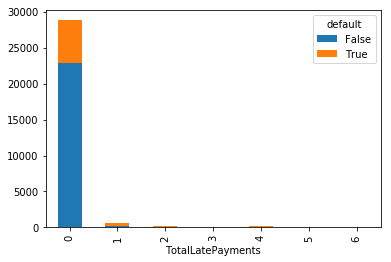

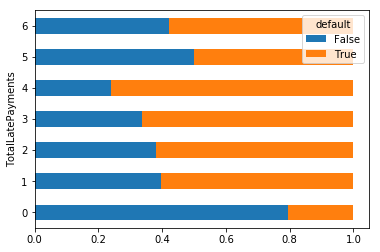

In [16]:
#  Default Rates increase with the number of times clients are 2 or more months late on their payments.
%matplotlib inline

Counts = pd.crosstab(df['TotalLatePayments'],df.default.astype(bool))
Counts.plot(kind='bar', stacked=True)#, ax=axes[fi,0])
    
Rate = Counts.div(Counts.sum(1).astype(float),axis=0)
Rate.plot(kind='barh', stacked=True)#, ax=axes[fi,1])
    
plt.show()

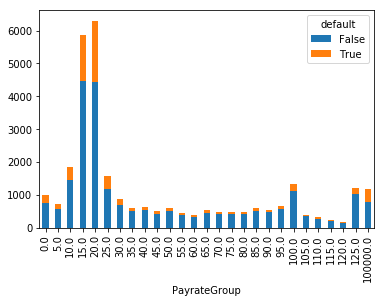

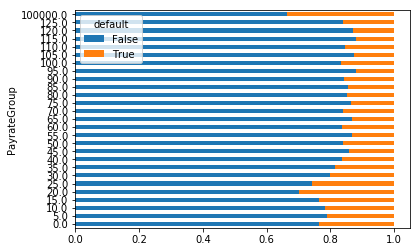

In [17]:
# Default Rates Increase with low payments as % of billed amounts.

Counts = pd.crosstab(df['PayrateGroup'],df.default.astype(bool))
Counts.plot(kind='bar', stacked=True)#, ax=axes[0,0])
    
Rate = Counts.div(Counts.sum(1).astype(float),axis=0)
Rate.plot(kind='barh', stacked=True)#, ax=axes[0,1])
    
plt.show()

In [ ]:
bins = [18, 25, 35, 45, 55, 65, 100]
labels = [0,1,2,3,4,5]
df['AGEGROUP'] = pd.cut(df['AGE'], bins=bins, labels=labels)

In [21]:
pd.crosstab(df['AGE'],df.AGEGROUP)

AGEGROUP,0,1,2,3,4,5
AGE,,,,,,
21,67,0,0,0,0,0
22,560,0,0,0,0,0
23,931,0,0,0,0,0
24,1127,0,0,0,0,0
25,1186,0,0,0,0,0
26,0,1256,0,0,0,0
27,0,1477,0,0,0,0
28,0,1409,0,0,0,0
29,0,1605,0,0,0,0
